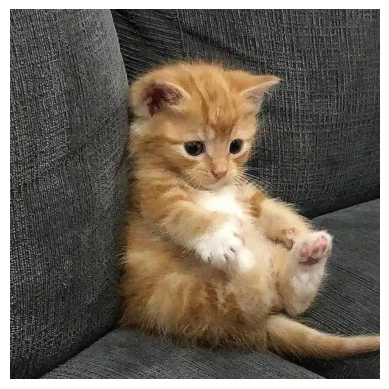

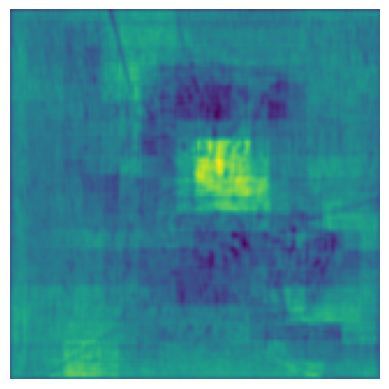

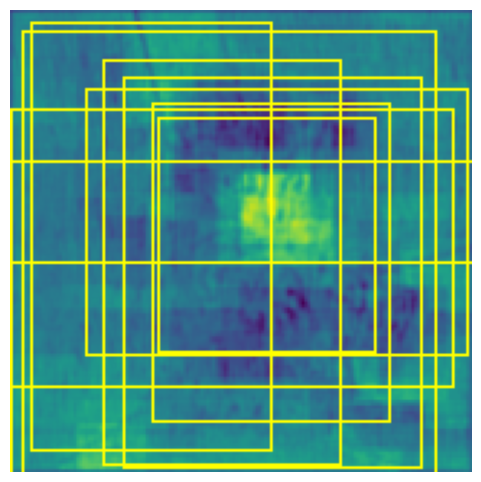

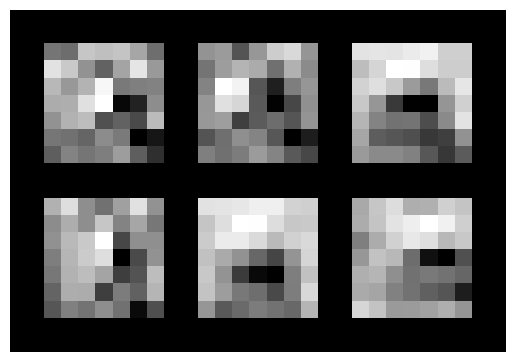

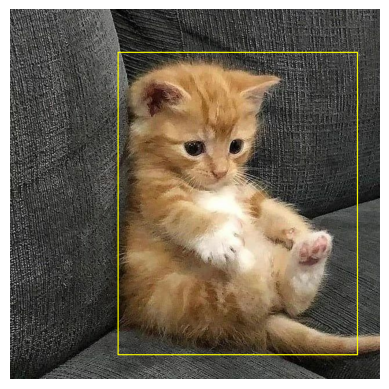

In [31]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
from torchvision.utils import draw_bounding_boxes
from einops import rearrange
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models.detection.image_list import ImageList

# Tự tạo ImageList từ tensor ảnh


# 1. Load ảnh và model
img = Image.open("img.jpg").convert("RGB")
img_tensor = F.to_tensor(img).unsqueeze(0)  # [1, 3, H, W]
H, W = img_tensor.shape[-2:]

model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

with torch.no_grad():
    # 2. Trích xuất feature maps từ FPN
    features = model.backbone(img_tensor[0].unsqueeze(0))
    fpn_maps = list(features.values())

    # 3. RPN proposals
    image_list = ImageList(img_tensor[0].unsqueeze(0), [(H, W)])
    proposals, _ = model.rpn(image_list, features)

    # 4. ROI Align
    roi_pool = model.roi_heads.box_roi_pool(features, proposals, [img_tensor.shape[-2:]])

    # 5. Final detections
    outputs = model(img_tensor)
    boxes = outputs[0]['boxes']
    scores = outputs[0]['scores']
    labels = outputs[0]['labels']

# -------------------------------
#  🔍 1. Hiển thị ảnh gốc
# plt.figure(figsize=(6, 6))
plt.imshow(img)
# plt.title("Ảnh gốc")
plt.axis("off")
plt.show()

# -------------------------------
#  🔍 2. Hiển thị 1 feature map từ FPN (ví dụ: '0')
feature = fpn_maps[0][0]  # shape [C, H, W]
feature_vis = feature.mean(0).cpu().numpy()

# plt.figure(figsize=(6, 6))
plt.imshow(feature_vis, cmap='viridis')
# plt.title("Feature Map FPN (stage 0, avg channel)")
plt.axis("off")
# plt.colorbar()
plt.show()

# -------------------------------
#  🔍 3. Hiển thị RPN proposals lên ảnh gốc
Hf, Wf = feature_map.shape[1:]

# Lấy proposal boxes (gốc theo ảnh): [x1, y1, x2, y2]
rpn_boxes = proposals[0][:10].clone()  # lấy 10 box đầu

# Scale từ ảnh → feature map (theo tỉ lệ spatial)
scale_x = Wf / W
scale_y = Hf / H

rpn_boxes[:, [0, 2]] *= scale_x
rpn_boxes[:, [1, 3]] *= scale_y
import cv2
from torchvision.transforms.functional import to_pil_image, to_tensor
# 1. Trích xuất feature và chuyển sang ảnh grayscale
feat_gray = feature.mean(0).cpu().numpy()  # [Hf, Wf]

# 2. Normalize về [0, 255]
feat_norm = (feat_gray - feat_gray.min()) / (feat_gray.max() - feat_gray.min())
feat_norm = (feat_norm * 255).astype(np.uint8)

# 3. Áp colormap viridis (OpenCV trả ảnh BGR)
feat_color = cv2.applyColorMap(feat_norm, cv2.COLORMAP_VIRIDIS)  # shape: [Hf, Wf, 3]
feat_color = cv2.cvtColor(feat_color, cv2.COLOR_BGR2RGB)    

# 4. Chuyển sang tensor
feat_tensor = to_tensor(feat_color) * 255  # [3, Hf, Wf], uint8

# 5. Vẽ box vàng
feature_with_roi = draw_bounding_boxes(feat_tensor.byte(), rpn_boxes, colors="yellow", width=1)

# 6. Hiển thị kết quả
plt.figure(figsize=(6, 6))
plt.imshow(feature_with_roi.permute(1, 2, 0).cpu())
# plt.title("RPN Proposals trên Feature Map màu viridis")
plt.axis("off")
plt.show()

# -------------------------------
#  🔍 4. Hiển thị 6 vùng sau ROI Align
roi_batch = roi_pool[:6]  # [N, C, 7, 7]
roi_imgs = rearrange(roi_batch.mean(1), 'n h w -> n 1 h w')  # [N, 1, 7, 7]



grid = torchvision.utils.make_grid(roi_imgs, nrow=3, normalize=True, scale_each=True)
# plt.figure(figsize=(6, 3))
plt.imshow(grid.permute(1, 2, 0).squeeze(), cmap='viridis')
# plt.title("ROI Align crops (mean over channel)")
plt.axis("off")
plt.show()

# -------------------------------
#  🔍 5. Final detection boxes
keep = scores > 0.7
img_final = draw_bounding_boxes((img_tensor[0] * 255).byte(), boxes[keep], colors="yellow", width=2)

# plt.figure(figsize=(6, 6))
plt.imshow(img_final.permute(1, 2, 0))
# plt.title("Final Detections (score > 0.7)")
plt.axis("off")
plt.show()
